In [18]:
import pandas as pd
import geopandas as gpd

from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [6]:
ref = pd.read_csv('../data/brexit_vote.csv', index_col='Area_Code')

In [7]:
ref.head(3)

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07


In [8]:
lads = gpd.read_file('../data/local_authority_districts.geojson').set_index('lad16cd')

In [9]:
lads.head(3)

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,NaN,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,NaN,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,NaN,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."


In [10]:
lads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
db = gpd.GeoDataFrame(

    lads.join(ref[['Pct_Leave']]), crs = lads.crs).to_crs(epsg=3857)[['objectid', 'lad16nm',
                                                                      'Pct_Leave', 'geometry']].dropna()

In [13]:
db.head(3)

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260..."


<Axes: >

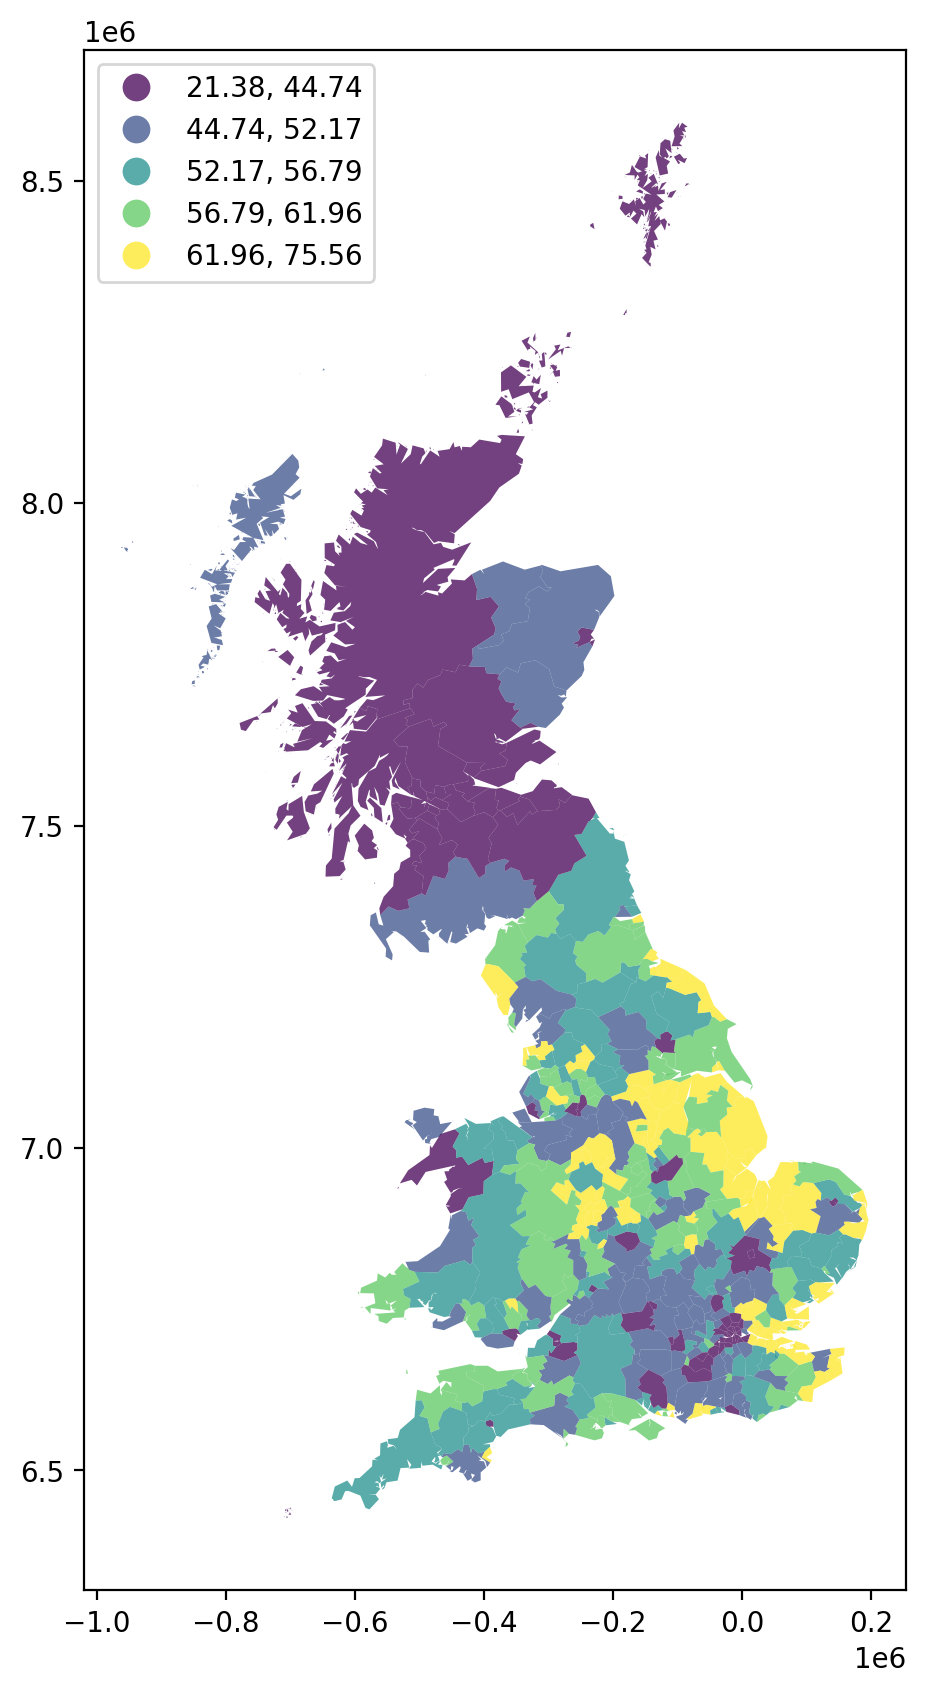

In [14]:
f, ax = plt.subplots(1, figsize=(20,10))
db.plot(column = 'Pct_Leave',
        cmap = 'viridis',
        scheme = 'quantiles',
        k = 5,
        edgecolor = 'white',
        linewidth=0.,
        alpha=0.75,
        legend=True,
        legend_kwds={'loc':2},
        ax = ax)

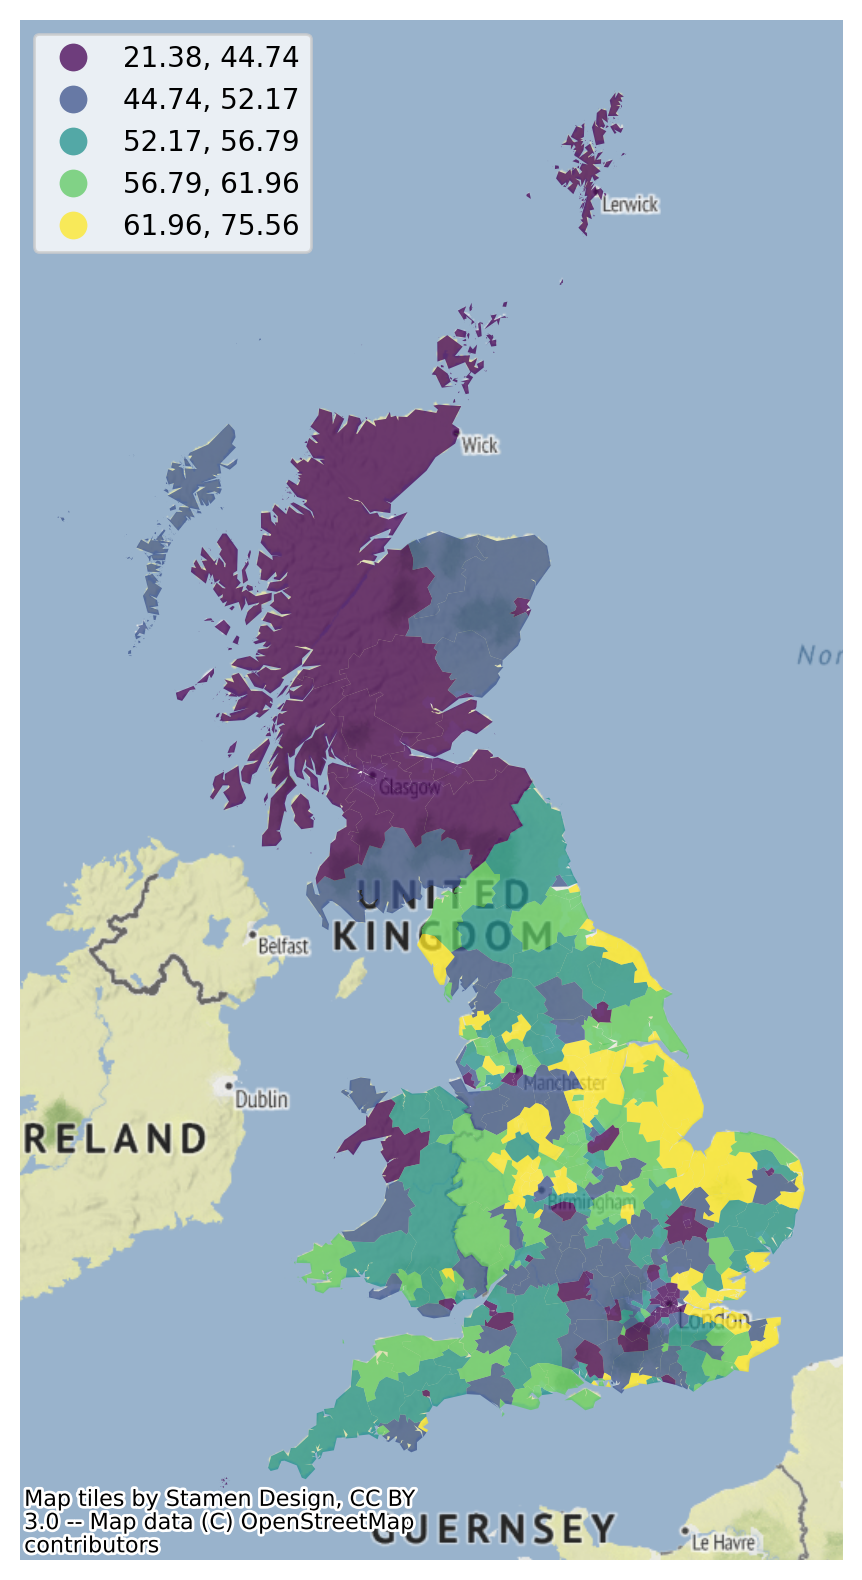

In [17]:
f, ax = plt.subplots(1, figsize=(20,10))
db.plot(column = 'Pct_Leave',
        cmap = 'viridis',
        scheme = 'quantiles',
        k = 5,
        edgecolor = 'white',
        linewidth=0.,
        alpha=0.75,
        legend=True,
        legend_kwds={'loc':2},
        ax = ax)

contextily.add_basemap(ax,
                       crs=db.crs,

                      )
ax.set_axis_off()

## Matriz de pesos

O código abaixo realiza a análise de pesos baseada na visinhança por KNN, sem necessidade de vizinhança fisica. Considerasse 8 vizinhos mais próximos.

In [19]:
w = weights.KNN.from_dataframe(db, k = 8) ### peso por distância

In [25]:
# curisoidade - método quadriculado
qW = weights.Queen.from_dataframe(db)

O método acima não consegue calcular peso em ilhas sem vizinhança. Isso mostra que náo é o mais adequado para esta aplicação.

In [23]:
# é preciso normalizar a matriz de pesos
# O código abaixo realiza a normalização com o transform em função das linhas (rows) com o parâmetro 'R'
w.transform = 'R'

## Média móvel espacial

Aqui, calcula-se qual deveria ser o valor da região baseado nos seus vizinhos, com um número máximo de 8 vizinhos de distância.

In [26]:
db['Pct_Leave_lag'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

In [27]:
db.head(3)

,objectid,lad16nm,Pct_Leave,geometry,Pct_Leave_lag
lad16cd,,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537...",60.92125
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426...",61.02625
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260...",60.65125


In [28]:
db.loc[['E08000012', 'S12000019'],
       ['Pct_Leave', 'Pct_Leave_lag']]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


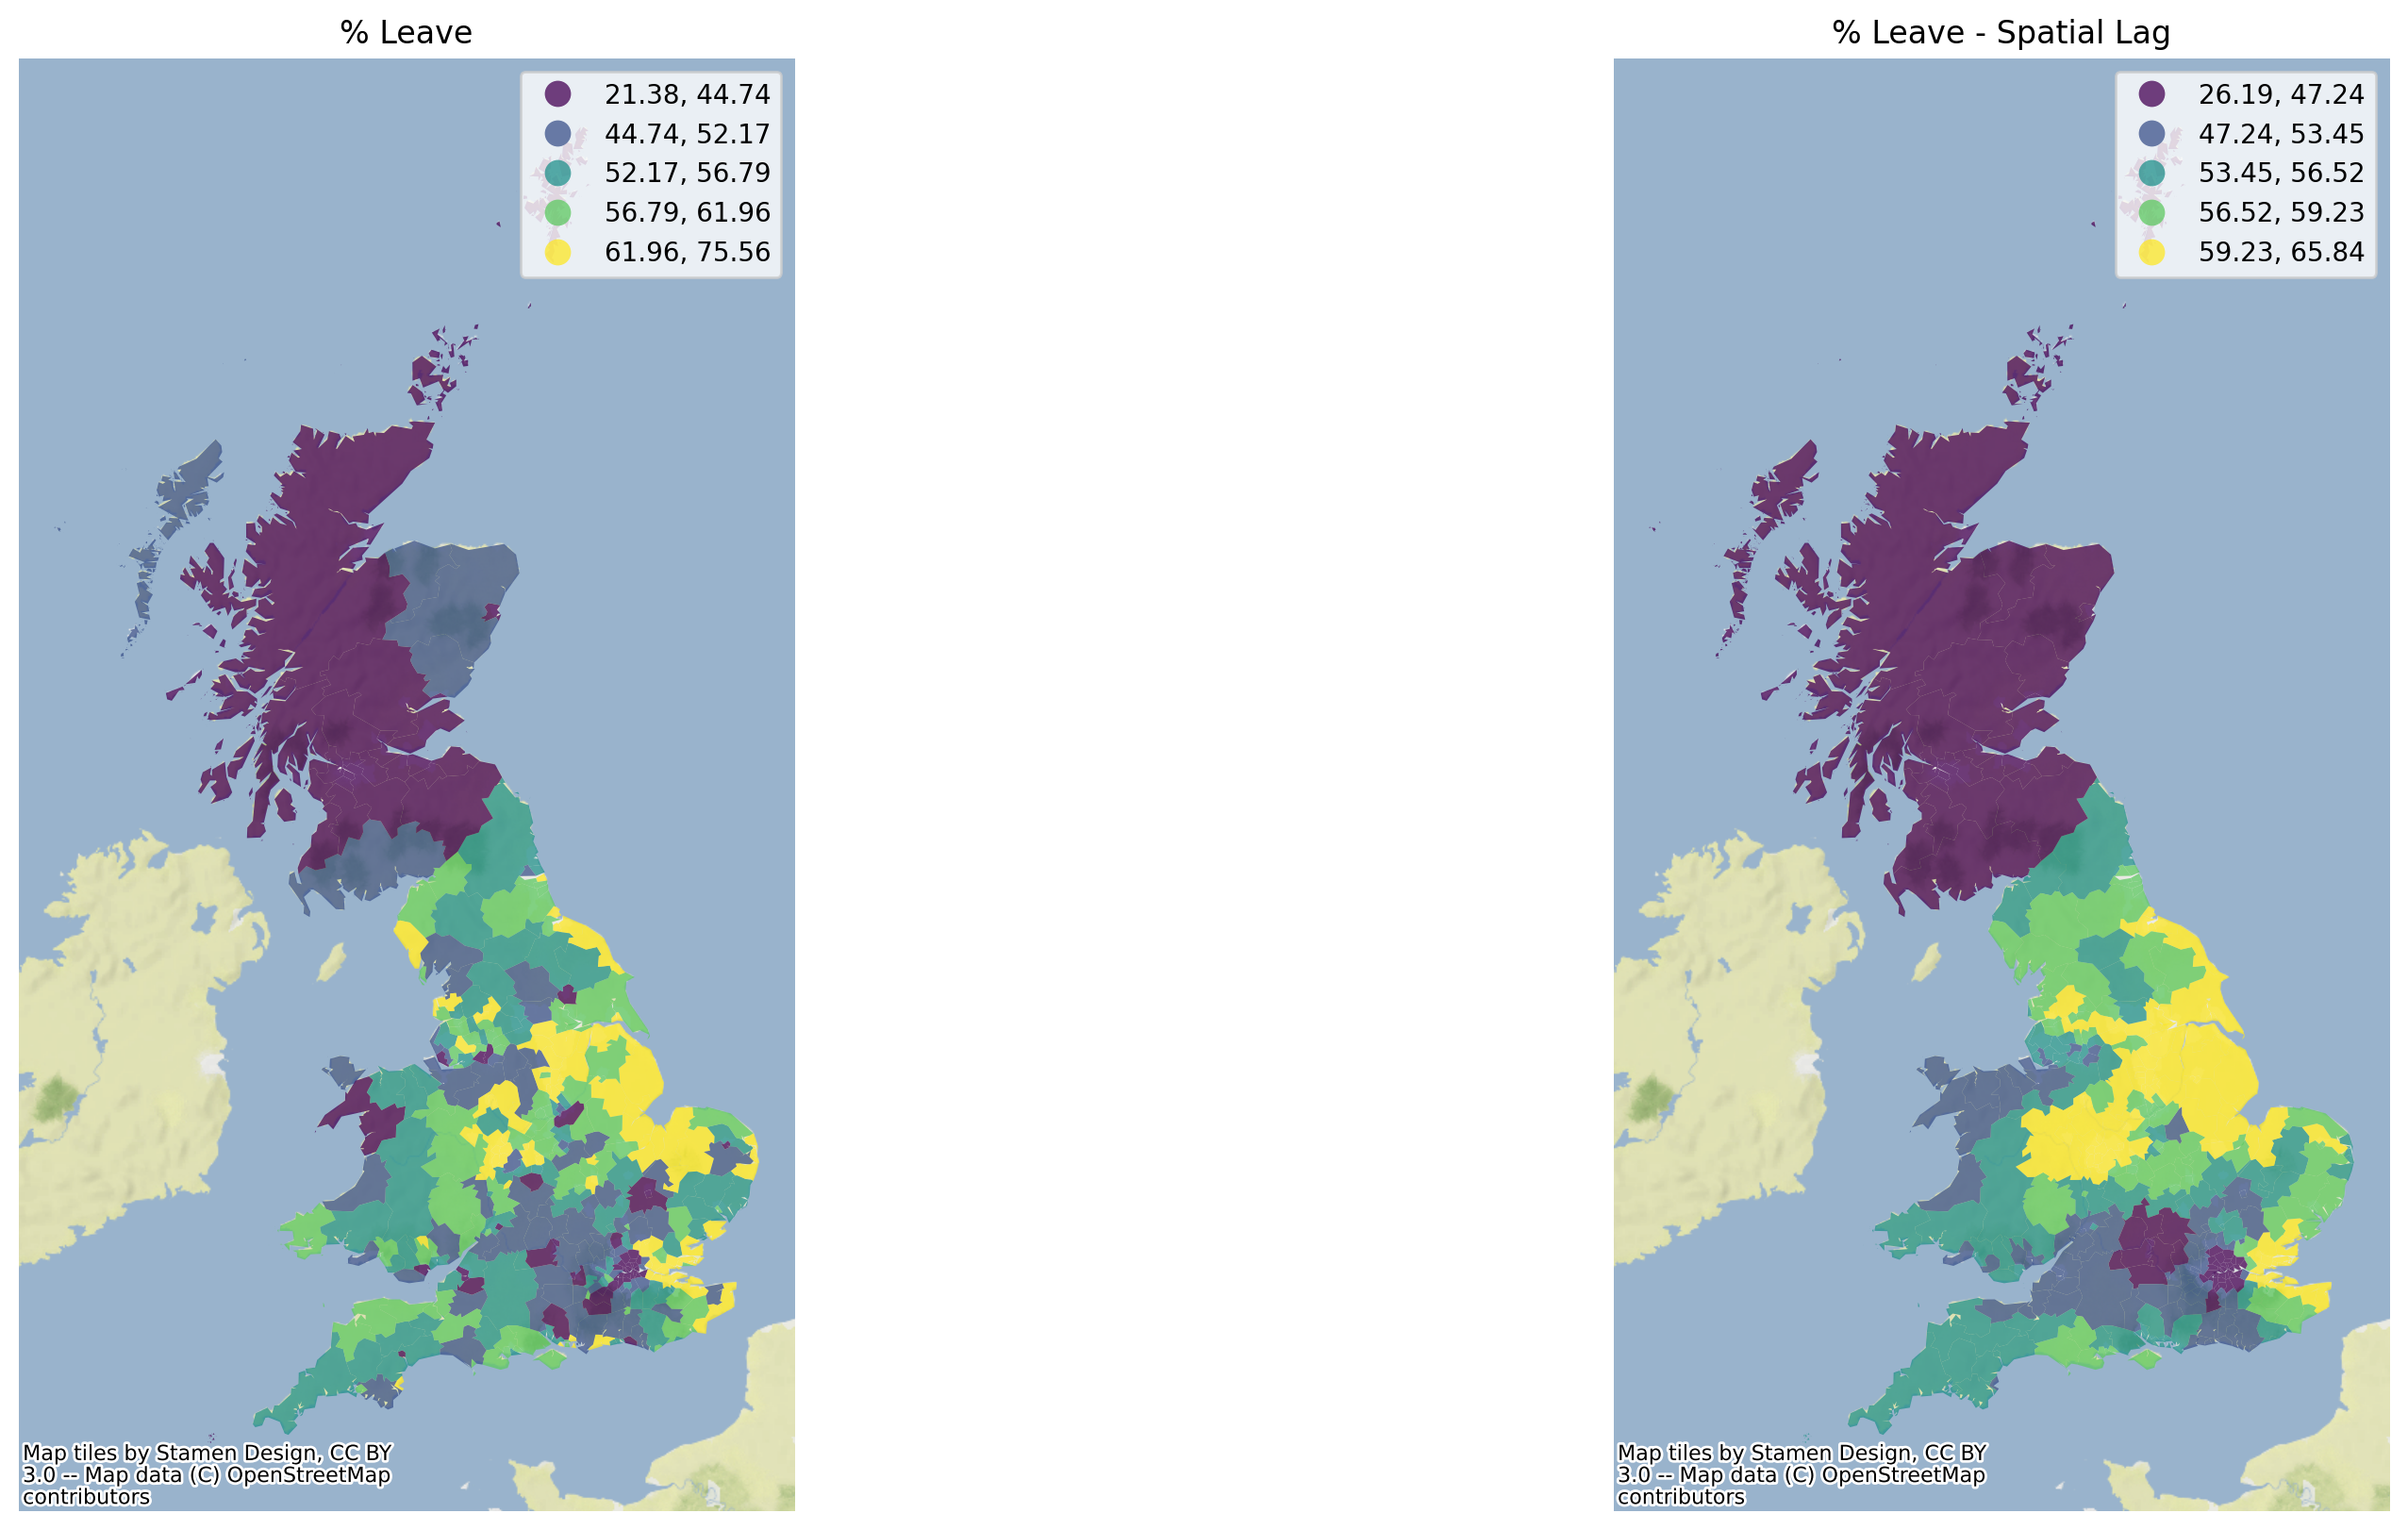

In [29]:
f, axs = plt.subplots(1, 2, figsize=(20,10))
ax1, ax2 = axs

db.plot(column='Pct_Leave', cmap = 'viridis', scheme='quantiles', k = 5,
        edgecolor='white', linewidth=0.0, alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title('% Leave')
contextily.add_basemap(ax1,
                       crs=db.crs,
                       source=contextily.providers.Stamen.TerrainBackground,

                      )

db.plot(column='Pct_Leave_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
contextily.add_basemap(ax2,
                       crs=db.crs,
                       source=contextily.providers.Stamen.TerrainBackground,

                      )

plt.show()

## Moran I

In [36]:
from esda.moran import Moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran

In [37]:
moran = Moran(db['Pct_Leave'], w)

In [38]:
moran.I

0.6454521298096587

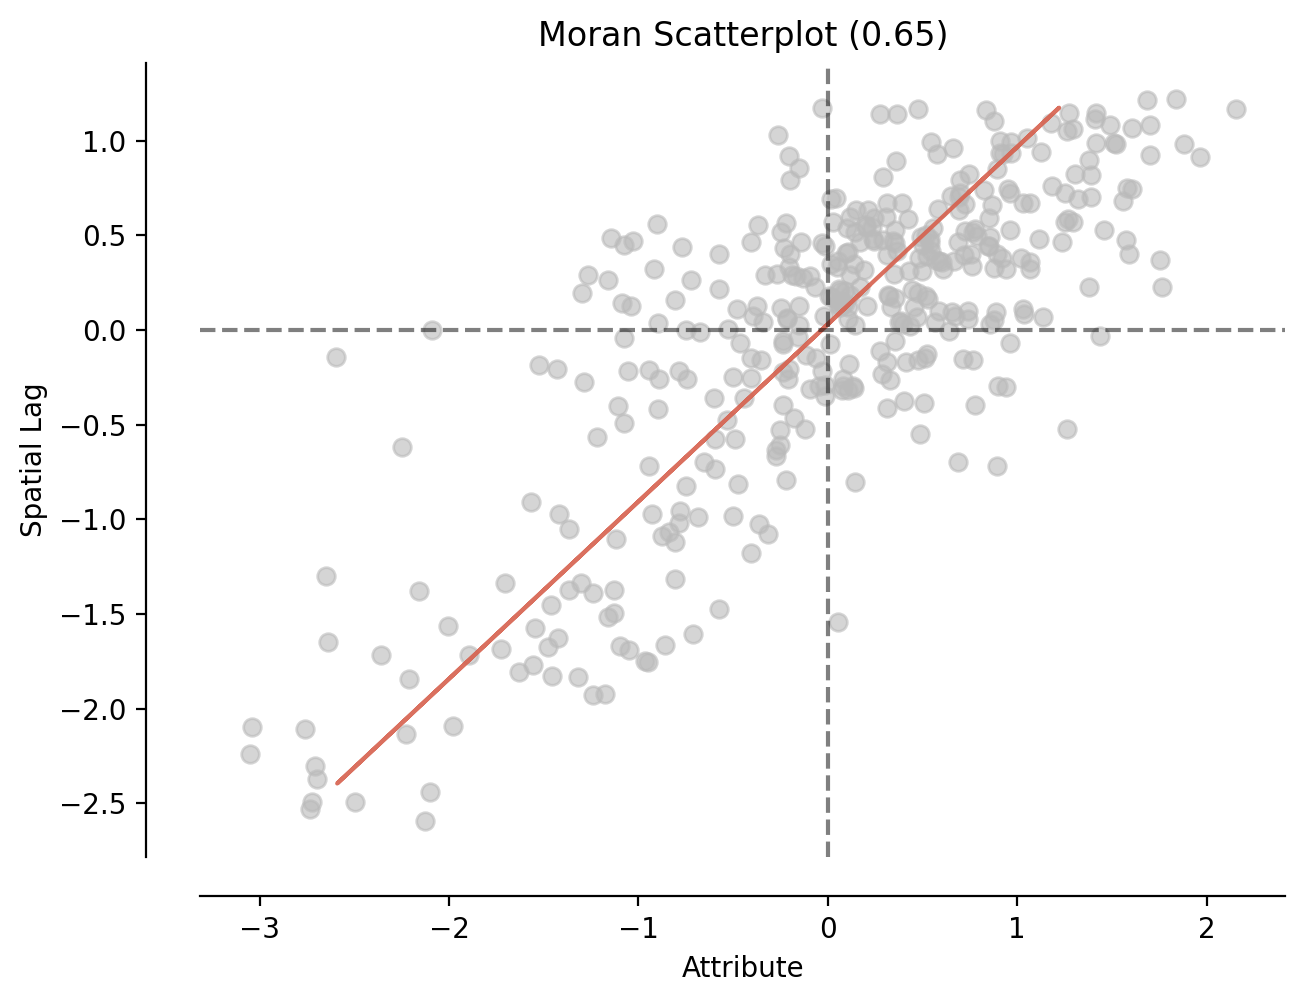

In [39]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/Users/fran-janela/Documents/Insper/8o/InfoGeo/aulas/env/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


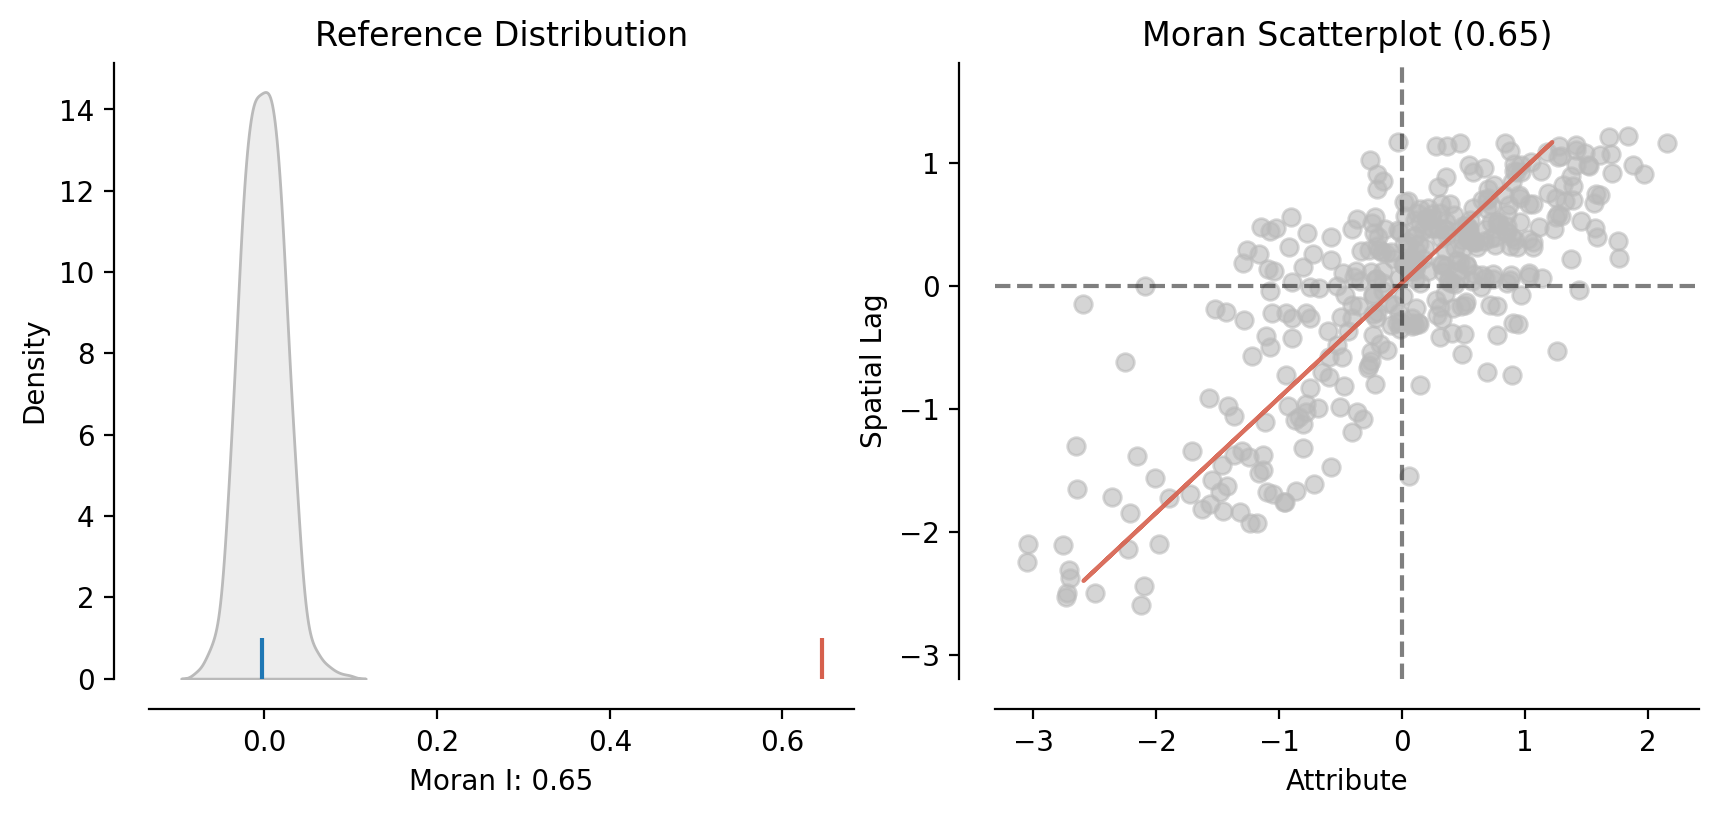

In [40]:
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

# LISA

In [45]:
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation

In [46]:
moran_loc = Moran_Local(db['Pct_Leave'], w)

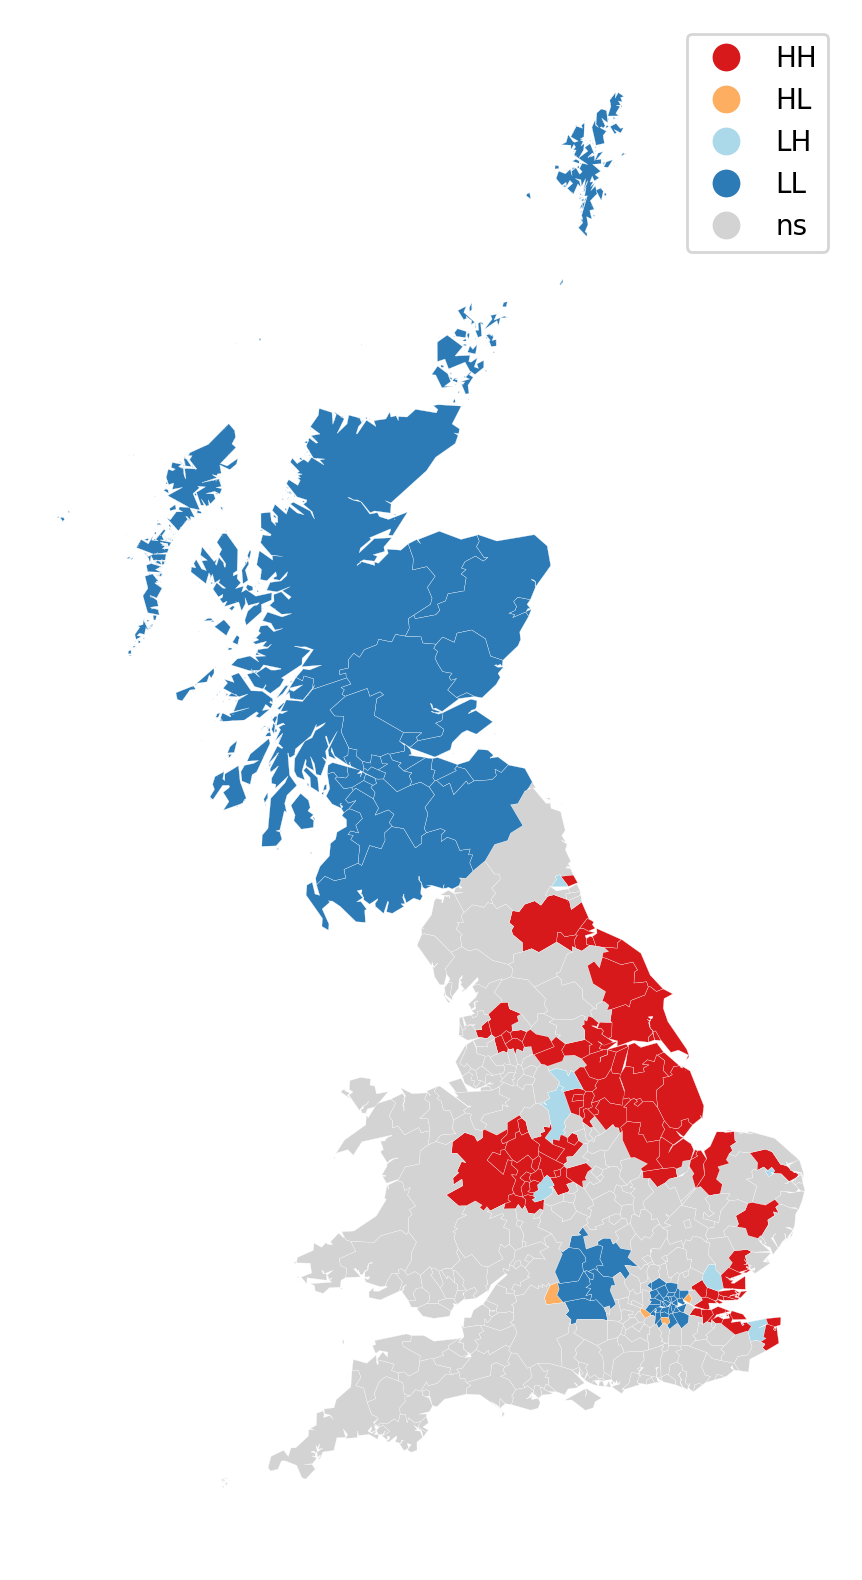

In [47]:
lisa_cluster(moran_loc, db, p=0.05, figsize = (10,10))
plt.show()

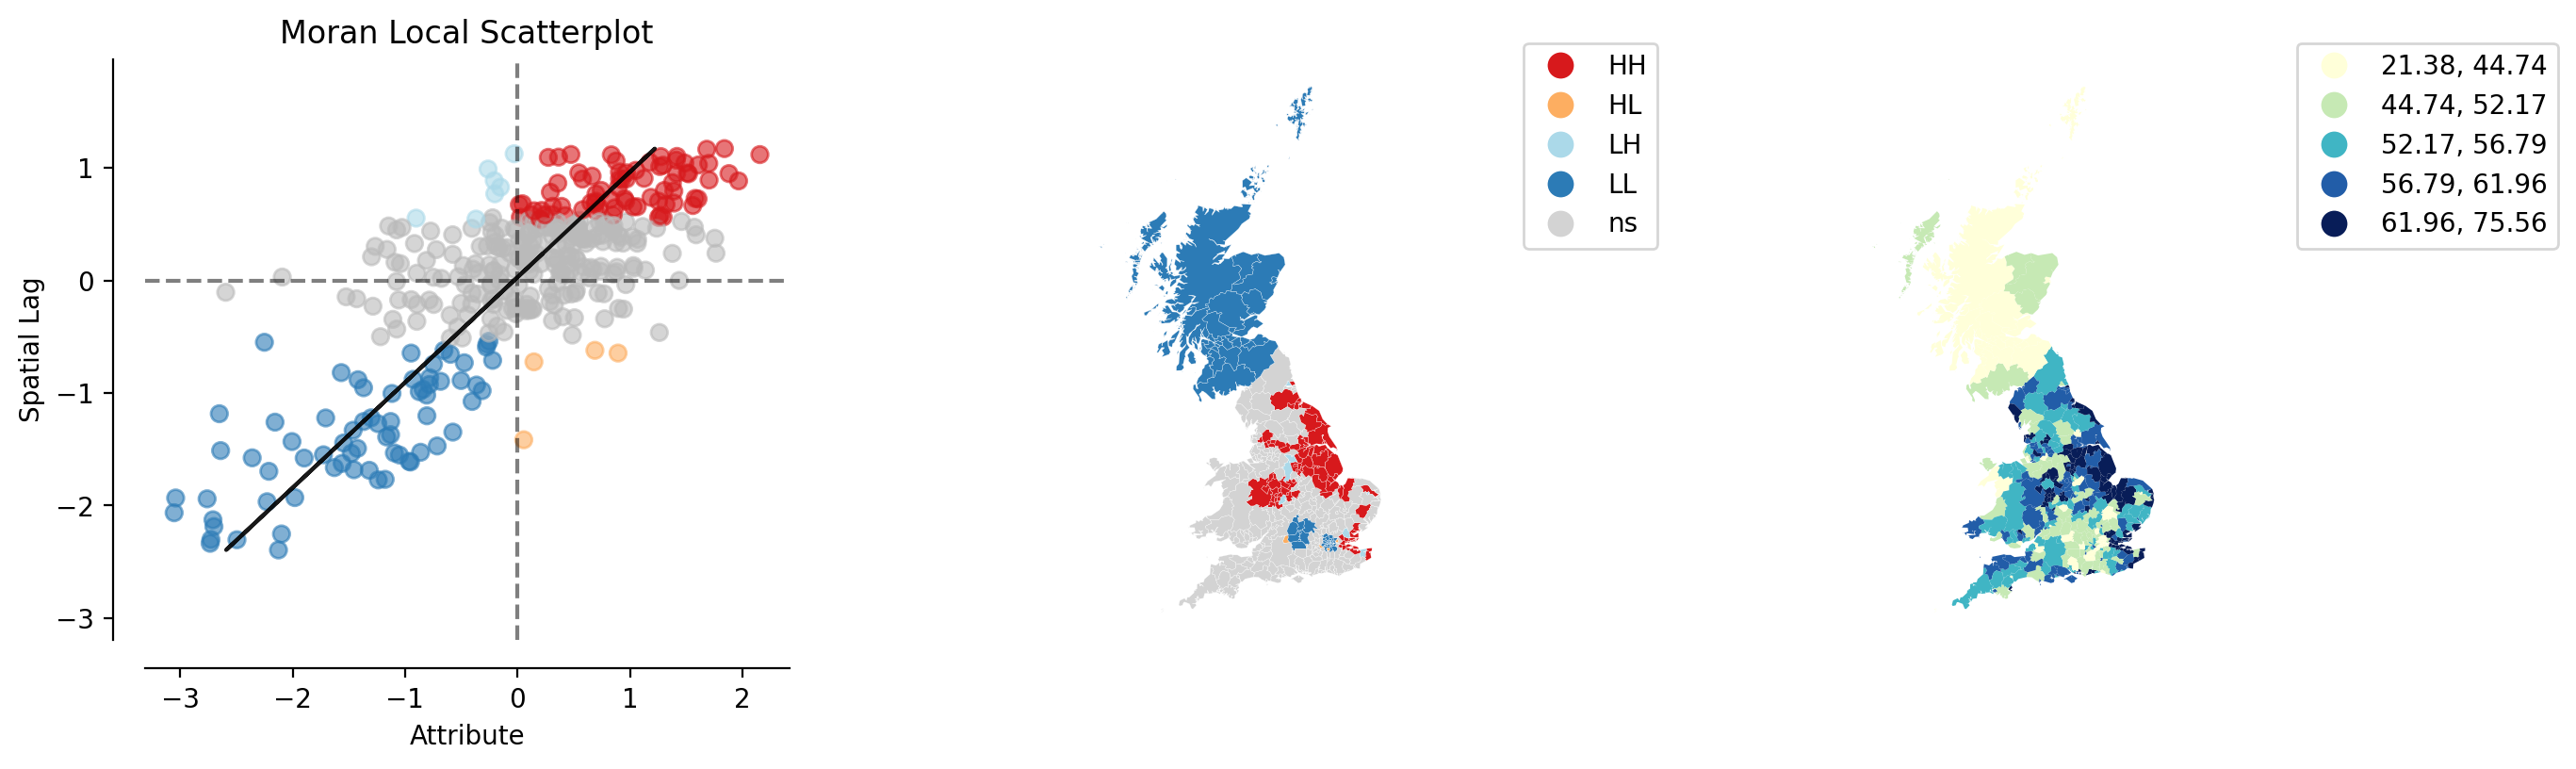

In [48]:
plot_local_autocorrelation(moran_loc, db,
                           'Pct_Leave')
plt.show()